Import the data

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv(
    'aps_3yr_jan21dec23_eul_withoutsmoking.tab',
    delimiter='\t',
    low_memory=False,
    dtype={
        'CLAIMS14': 'Int64',
        'CombinedAuthorities': 'string'
    }
)

df.head()

,AAGE,ACTHR,ACTHR2,ACTPOT,ACTUOT,ACTWKDY1,ACTWKDY2,ACTWKDY3,ACTWKDY4,ACTWKDY5,...,XDISDDA20,Y2JOB,YLESS20,YMORE,YPAYL20,YPAYM,YPTJOB,YSTART,YTETJB,YVARY99
0,13,-9.0,-9.0,-9.0,-9.0,2,3,-9,-9,-9,...,4,-9,-9,-9,-9,-9,4,-9,-9,-9
1,13,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,-9,...,4,-9,-9,-9,-9,-9,-9,-9,-9,-9
2,11,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,-9,...,1,-9,-9,-9,-9,-9,-9,-9,-9,-9
3,12,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,-9,...,1,-9,-9,-9,-9,-9,-9,5,-9,-9
4,13,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,-9,...,4,-9,-9,-9,-9,-9,-9,-9,-9,-9


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341465 entries, 0 to 341464
Columns: 459 entries, AAGE to YVARY99
dtypes: Int64(1), float64(20), int64(423), object(14), string(1)
memory usage: 1.2+ GB


In [4]:
# Define what counts as "missing" for the summary
special_missing_codes = [-8]

# Create a mask: True if NaN OR special code
missing_mask = df.isna() | df.isin(special_missing_codes)

# Count missing values
missing_counts = missing_mask.sum()

# Calculate percentage
missing_percent = (missing_counts / len(df)) * 100

# Combine into a summary table and sort
missing_data_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent.round(2)
}).sort_values(by='Missing Count', ascending=False)

# Show top 10 only
top10_missing = missing_data_summary.head(10)

top10_missing

,Missing Count,Missing %
GRSSWK,28924,8.47
NETWK,27105,7.94
RELIG11,20828,6.1
REDUND,5336,1.56
PAIDHRU,3122,0.91
DIFFHR20,3092,0.91
TTUSHR,3026,0.89
BUSHR,2469,0.72
CONMON,2294,0.67
BANDN,2222,0.65


In [5]:
# Step 1: Define the wellbeing columns
wellbeing_items = ['SATIS', 'WORTH', 'HAPPY']

# Step 2: Drop rows where all three are invalid (-8 or -9)
invalid_mask = (df[wellbeing_items] <= -8).all(axis=1)
df = df[~invalid_mask].copy()

# Step 3: Replace -8 and -9 with NaN temporarily to compute column means
temp = df[wellbeing_items].replace({-8: np.nan, -9: np.nan})

# Step 4: Compute column means (excluding -8/-9)
col_means = temp.mean()

# Print the column means
print("\nColumn means (excluding -8 and -9):")
print(col_means)

# Step 5: Replace -8 and -9 with their respective column means
for col in wellbeing_items:
    df[col] = df[col].replace({-8: col_means[col], -9: col_means[col]})

# Step 6: Compute Wellbeing score as row-wise average
df['Wellbeing'] = df[wellbeing_items].mean(axis=1)

# Optional: Preview
print("\nSample of cleaned data:")
print(df[['SATIS', 'WORTH', 'HAPPY', 'Wellbeing']].head())


Column means (excluding -8 and -9):
SATIS    7.553688
WORTH    7.856793
HAPPY    7.509492
dtype: float64

Sample of cleaned data:
   SATIS  WORTH  HAPPY  Wellbeing
0    8.0    8.0    7.0   7.666667
1   10.0    8.0   10.0   9.333333
2   10.0    9.0   10.0   9.666667
4    8.0    5.0    8.0   7.000000
5    8.0    8.0    7.0   7.666667


In [6]:
def classify_wellbeing(score):
    if pd.isna(score):
        return pd.NA
    elif score < 4:
        return 0
    elif score < 6:
        return 1
    elif score < 8:
        return 2
    elif score <= 10:
        return 3
    else:
        return pd.NA  # catches any out-of-range values

df['Wellbeing_category'] = df['Wellbeing'].apply(classify_wellbeing).astype('Int64')

df[['Wellbeing', 'Wellbeing_category']].head()

,Wellbeing,Wellbeing_category
0,7.666667,2
1,9.333333,3
2,9.666667,3
4,7.000000,2
5,7.666667,2


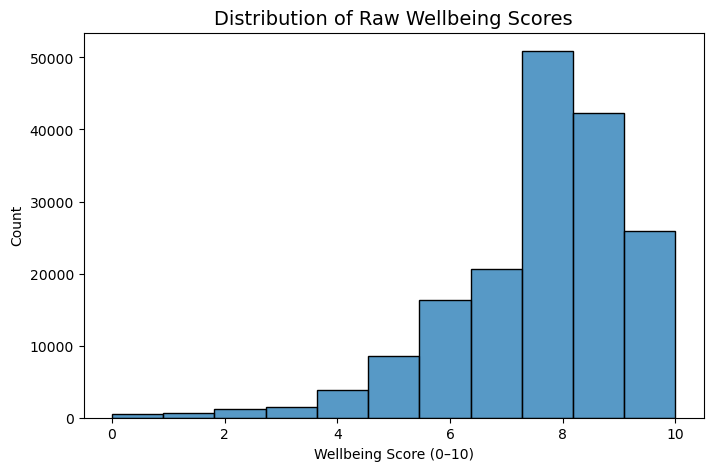

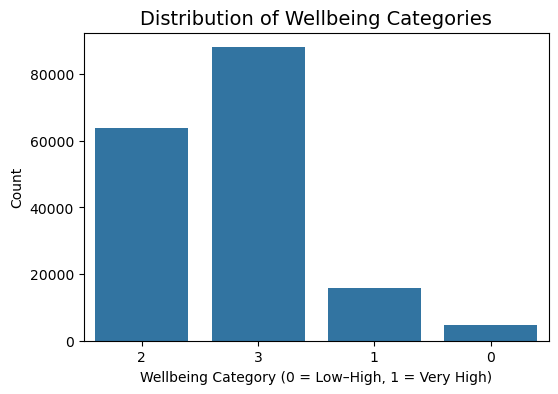

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Distribution of raw Wellbeing scores ---
plt.figure(figsize=(8,5))
sns.histplot(df['Wellbeing'].dropna(), bins=11, kde=False)
plt.title("Distribution of Raw Wellbeing Scores", fontsize=14)
plt.xlabel("Wellbeing Score (0–10)")
plt.ylabel("Count")
plt.show()

# --- Distribution of binary Wellbeing_category ---
plt.figure(figsize=(6,4))
sns.countplot(x=df['Wellbeing_category'].astype(str))
plt.title("Distribution of Wellbeing Categories", fontsize=14)
plt.xlabel("Wellbeing Category (0 = Low–High, 1 = Very High)")
plt.ylabel("Count")
plt.show()

In [8]:
# Step 1: Define HEALPB2001 to HEALPB2010
health_cols = [f'HEALPB20{str(i).zfill(2)}' for i in range(1, 11)]

# Step 2: Ensure correct dtype and replace -8 with NaN (keep -9)
df[health_cols] = df[health_cols].astype('Int64')

# Step 3: Define mapping of health code to descriptive name
health_labels = {
    1: "ArmsOrHands",
    2: "LegsOrFeet",
    3: "BackOrNeck",
    4: "SeeingDifficulty",
    5: "HearingDifficulty",
    6: "SpeechImpediment",
    7: "Disfigurements",
    8: "BreathingProblems",
    9: "HeartOrCirculation",
    10: "DigestiveOrgans",
    11: "Diabetes",
    12: "MentalAnxiety",
    13: "Epilepsy",
    14: "LearningDifficulties",
    15: "MentalIllness",
    16: "ProgressiveIllness",
    17: "OtherProblems",
    18: "Autism"
}

# Step 4: Efficient one-pass creation of HEALTH_* columns
for code, label in health_labels.items():
    col_name = f'HEALTH_{label}'

    if col_name not in df.columns:
        # Use vectorized comparison and any across the row
        df[col_name] = (df[health_cols] == code).any(axis=1).astype(int)

print("Optimized HEALTH columns created.")

Optimized HEALTH columns created.


In [9]:
# Columns to remove(columns that have missing value over 5% and redundant columns, IDREF has no meaning)
cols_to_remove = ['GRSSWK', 'NETWK', 'RELIG11', 'SATIS', 'WORTH', 'HAPPY', 'Wellbeing','IDREF']

# Drop the columns
df_filtered = df.drop(columns=cols_to_remove, errors='ignore')

# Define what counts as "missing" for the summary
special_missing_codes = [-8]

# Create a mask: True if NaN OR special code
missing_mask = df_filtered.isna() | df_filtered.isin(special_missing_codes)

# Count missing values
missing_counts = missing_mask.sum()

# Calculate percentage
missing_percent = (missing_counts / len(df_filtered)) * 100

# Combine into a summary table and sort
missing_data_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent.round(2)
}).sort_values(by='Missing Count', ascending=False)

# Show top 10 only
df_filtered.info()
top10_missing = missing_data_summary.head(10)

top10_missing

<class 'pandas.core.frame.DataFrame'>
Index: 172333 entries, 0 to 341464
Columns: 471 entries, AAGE to HEALTH_Autism
dtypes: Int64(12), float64(20), int64(424), object(14), string(1)
memory usage: 622.6+ MB


,Missing Count,Missing %
PAIDHRU,1229,0.71
TTUSHR,1190,0.69
DIFFHR20,1090,0.63
BUSHR,955,0.55
REDUND,848,0.49
DISEA,779,0.45
BANDG,719,0.42
LEFTM,683,0.4
WNLEFT11,588,0.34
WN2LFT11,588,0.34


In [10]:
# Show only categorical columns (object, string, category types)
categorical_cols = df_filtered.select_dtypes(include=['object', 'string', 'category']).columns.tolist()

print("Number of categorical features:", len(categorical_cols))
print("Categorical features:", categorical_cols)

binary_cols = [col for col in df_filtered.columns if df_filtered[col].nunique() == 2]

print("Number of binary features:", len(binary_cols))
print("Binary features:", binary_cols)

Number of categorical features: 15
Categorical features: ['CombinedAuthorities', 'CombinedAuthoritiescensus2021', 'CTRY9D', 'FDSNGDEG', 'GOR9d', 'GOR9dcensus2021', 'ITL221', 'ITL321', 'ITL221census2021', 'ITL321census2021', 'NUTS162', 'NUTS163', 'PARK', 'SNGDEGN', 'SNGHD']
Number of binary features: 38
Binary features: ['BONCMP4', 'ERNCM06', 'GB', 'HALLRES', 'HEALPB2010', 'HRPID', 'ILLDAYS7', 'JB2T103', 'LFSSAMP', 'MARDY6', 'METHAL13', 'METHMP11', 'METHSE6', 'MF1664', 'PENBN133', 'REDP3', 'SEX', 'STUCUR', 'TYPINT', 'UNDY985', 'HEALTH_ArmsOrHands', 'HEALTH_LegsOrFeet', 'HEALTH_BackOrNeck', 'HEALTH_SeeingDifficulty', 'HEALTH_HearingDifficulty', 'HEALTH_SpeechImpediment', 'HEALTH_Disfigurements', 'HEALTH_BreathingProblems', 'HEALTH_HeartOrCirculation', 'HEALTH_DigestiveOrgans', 'HEALTH_Diabetes', 'HEALTH_MentalAnxiety', 'HEALTH_Epilepsy', 'HEALTH_LearningDifficulties', 'HEALTH_MentalIllness', 'HEALTH_ProgressiveIllness', 'HEALTH_OtherProblems', 'HEALTH_Autism']


In [11]:
from sklearn.preprocessing import LabelEncoder

# Copy your dataframe to keep original safe
df_encoded = df_filtered.copy()

# Detect categorical columns
categorical_cols = df_encoded.select_dtypes(include=['object', 'string', 'category']).columns.tolist()

# Exclude 'Wellbeing_category'
categorical_cols = [col for col in categorical_cols if col != 'Wellbeing_category']

print(f"Categorical columns to encode ({len(categorical_cols)}): {categorical_cols}")

# Encode each categorical column separately
for col in categorical_cols:
    le = LabelEncoder()
    # Fill NaN with a placeholder string
    df_encoded[col] = df_encoded[col].fillna('missing').astype(str)
    # Fit and transform to numeric labels
    df_encoded[col] = le.fit_transform(df_encoded[col])

Categorical columns to encode (15): ['CombinedAuthorities', 'CombinedAuthoritiescensus2021', 'CTRY9D', 'FDSNGDEG', 'GOR9d', 'GOR9dcensus2021', 'ITL221', 'ITL321', 'ITL221census2021', 'ITL321census2021', 'NUTS162', 'NUTS163', 'PARK', 'SNGDEGN', 'SNGHD']


In [12]:
# Show data types of each column
print(df_encoded.dtypes)

# Or for a nicer summary with counts per type:
print(df_encoded.dtypes.value_counts())

# If you want to see data types alongside the first few rows:
print(df_encoded.info())

AAGE                             int64
ACTHR                          float64
ACTHR2                         float64
ACTPOT                         float64
ACTUOT                         float64
                                ...   
HEALTH_LearningDifficulties      int64
HEALTH_MentalIllness             int64
HEALTH_ProgressiveIllness        int64
HEALTH_OtherProblems             int64
HEALTH_Autism                    int64
Length: 471, dtype: object
int64      439
float64     20
Int64       12
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 172333 entries, 0 to 341464
Columns: 471 entries, AAGE to HEALTH_Autism
dtypes: Int64(12), float64(20), int64(439)
memory usage: 622.6 MB
None


In [14]:
from sklearn.model_selection import train_test_split
#Train-test-valid split
train_data, temp_data = train_test_split(df_encoded, test_size=0.30, random_state=42, stratify=df_encoded['Wellbeing_category'])
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['Wellbeing_category'])

print(f"Train shape: {train_data.shape}")
print(f"Validation shape: {val_data.shape}")
print(f"Test shape: {test_data.shape}")

Train shape: (120633, 471)
Validation shape: (25850, 471)
Test shape: (25850, 471)


In [15]:
print("Train Wellbeing_category distribution:")
print(train_data['Wellbeing_category'].value_counts(normalize=False))

print("\nValidation Wellbeing_category distribution:")
print(val_data['Wellbeing_category'].value_counts(normalize=False))

print("\nTest Wellbeing_category distribution:")
print(test_data['Wellbeing_category'].value_counts(normalize=False))

Train Wellbeing_category distribution:
Wellbeing_category
3    61610
2    44730
1    10989
0     3304
Name: count, dtype: Int64

Validation Wellbeing_category distribution:
Wellbeing_category
3    13202
2     9585
1     2355
0      708
Name: count, dtype: Int64

Test Wellbeing_category distribution:
Wellbeing_category
3    13202
2     9585
1     2355
0      708
Name: count, dtype: Int64


In [16]:
from imblearn.over_sampling import SMOTE

# --- Separate features and target ---
X_train = train_data.drop(columns=['Wellbeing_category'])
y_train = train_data['Wellbeing_category']

X_val = val_data.drop(columns=['Wellbeing_category'])
y_val = val_data['Wellbeing_category']

X_test = test_data.drop(columns=['Wellbeing_category'])
y_test = test_data['Wellbeing_category']

# --- Convert targets to numpy int ---
y_train = y_train.to_numpy().astype(int)
y_val   = y_val.to_numpy().astype(int)
y_test  = y_test.to_numpy().astype(int)

# --- Convert features to float (fixes SMOTE issue) ---
X_train = X_train.astype(float)
X_val   = X_val.astype(float)
X_test  = X_test.astype(float)

# --- Apply SMOTE on training set only ---
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Class distribution before SMOTE:\n", pd.Series(y_train).value_counts())
print("Class distribution after SMOTE:\n", pd.Series(y_train_res).value_counts())

Class distribution before SMOTE:
 3    61610
2    44730
1    10989
0     3304
Name: count, dtype: int64
Class distribution after SMOTE:
 2    61610
3    61610
1    61610
0    61610
Name: count, dtype: int64


Training Accuracy: 1.0
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3304
           1       1.00      1.00      1.00     10989
           2       1.00      1.00      1.00     44730
           3       1.00      1.00      1.00     61610

    accuracy                           1.00    120633
   macro avg       1.00      1.00      1.00    120633
weighted avg       1.00      1.00      1.00    120633



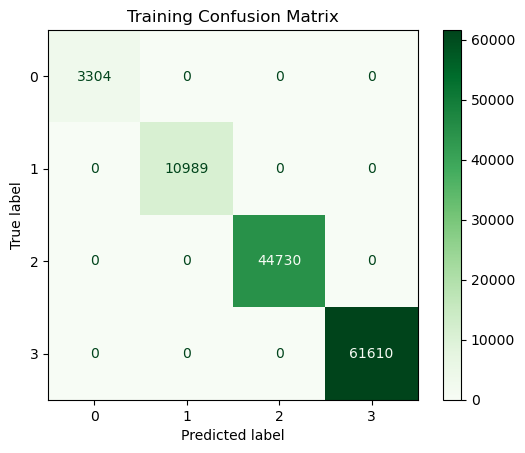

Training AUC-ROC: 1.0000
Validation Accuracy: 0.5873114119922631
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.04      0.08       708
           1       0.35      0.08      0.13      2355
           2       0.50      0.47      0.49      9585
           3       0.64      0.79      0.71     13202

    accuracy                           0.59     25850
   macro avg       0.48      0.35      0.35     25850
weighted avg       0.56      0.59      0.56     25850



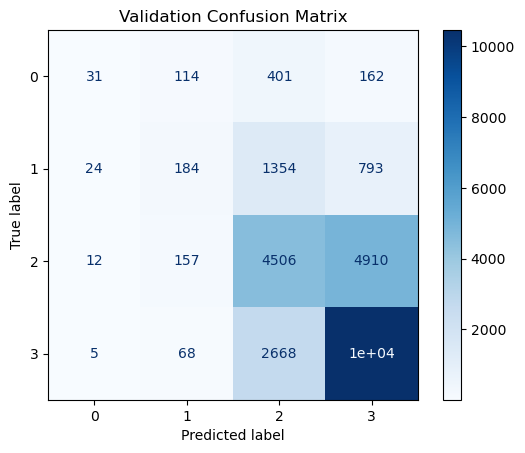

Validation AUC-ROC: 0.7487
Test Accuracy: 0.5815473887814313
Test Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.03      0.06       708
           1       0.34      0.07      0.12      2355
           2       0.49      0.46      0.48      9585
           3       0.64      0.79      0.71     13202

    accuracy                           0.58     25850
   macro avg       0.45      0.34      0.34     25850
weighted avg       0.55      0.58      0.55     25850



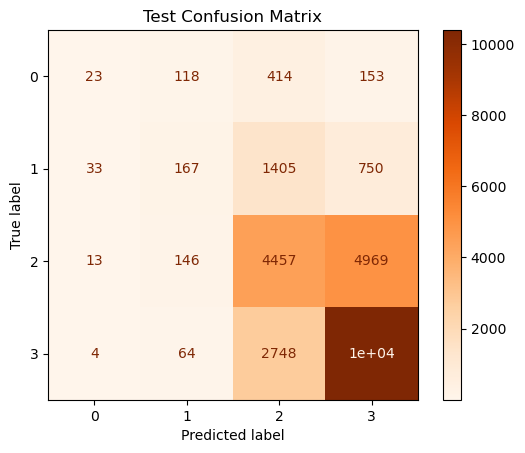

Test AUC-ROC: 0.7434


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score
)
import matplotlib.pyplot as plt

# Initialize the model
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Train on training data
rf_clf.fit(X_train, y_train)

# ---------------------------
# Training performance
# ---------------------------
train_preds = rf_clf.predict(X_train)
train_probs = rf_clf.predict_proba(X_train)

print("Training Accuracy:", accuracy_score(y_train, train_preds))
print("Training Classification Report:")
print(classification_report(y_train, train_preds))

cm_train = confusion_matrix(y_train, train_preds)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot(cmap=plt.cm.Greens)
plt.title("Training Confusion Matrix")
plt.show()

auc_train = roc_auc_score(y_train, train_probs, multi_class="ovr")
print(f"Training AUC-ROC: {auc_train:.4f}")

# ---------------------------
# Validation performance
# ---------------------------
val_preds = rf_clf.predict(X_val)
val_probs = rf_clf.predict_proba(X_val)

print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print("Validation Classification Report:")
print(classification_report(y_val, val_preds))

cm_val = confusion_matrix(y_val, val_preds)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()

auc_val = roc_auc_score(y_val, val_probs, multi_class="ovr")
print(f"Validation AUC-ROC: {auc_val:.4f}")

# ---------------------------
# Test performance
# ---------------------------
test_preds = rf_clf.predict(X_test)
test_probs = rf_clf.predict_proba(X_test)

print("Test Accuracy:", accuracy_score(y_test, test_preds))
print("Test Classification Report:")
print(classification_report(y_test, test_preds))

cm_test = confusion_matrix(y_test, test_preds)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(cmap=plt.cm.Oranges)
plt.title("Test Confusion Matrix")
plt.show()

auc_test = roc_auc_score(y_test, test_probs, multi_class="ovr")
print(f"Test AUC-ROC: {auc_test:.4f}")

In [18]:
from sklearn.metrics import normalized_mutual_info_score

# Target column
target = 'Wellbeing_category'

# Make sure target is label-encoded (if not already)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df_encoded[target].astype(str))

# Store results
nmi_scores = {}

for col in df_encoded.columns:
    if col != target:
        nmi = normalized_mutual_info_score(y, df_encoded[col])
        nmi_scores[col] = nmi

# Convert to DataFrame for sorting
nmi_df = pd.DataFrame(list(nmi_scores.items()), columns=['Feature', 'NMI'])
nmi_df = nmi_df.sort_values(by='NMI', ascending=False)

nmi_df.head(20)  

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserW

,Feature,NMI
14,ANXIOUS,0.068929
62,DISCURR20,0.032295
212,LIMACT,0.032255
63,DISEA,0.030796
318,REDACT,0.030760
213,LIMITA,0.028069
442,XDISDDA20,0.027964
54,DISBEN1,0.027844
214,LIMITK,0.027833
178,INECAC05,0.025258


In [19]:
# --- Redundancy penalty filtering---
corr_threshold = 0.9  # % alike
corr_matrix = df_encoded.drop(columns=[target]).corr().abs()

selected_features = []
eliminated_features = []

for feature in nmi_df['Feature']:
    # Find if this feature is too correlated with any already selected one
    too_correlated_with = None
    max_corr_value = 0

    for sel in selected_features:
        corr_value = corr_matrix.loc[feature, sel]
        if corr_value >= corr_threshold:
            too_correlated_with = sel
            max_corr_value = corr_value
            break

    if too_correlated_with is None:
        selected_features.append(feature)
    else:
        eliminated_features.append({
            "Feature": feature,
            "Correlated With": too_correlated_with,
            "Correlation": max_corr_value
        })

# --- Output ---
print("\nSelected Features:")
print(selected_features)

print("\nliminated Features (with reasons):")
for elim in eliminated_features:
    print(f"{elim['Feature']} eliminated because correlation with {elim['Correlated With']} = {elim['Correlation']:.2f}")


Selected Features:
['ANXIOUS', 'DISCURR20', 'LIMACT', 'REDACT', 'LIMITA', 'DISBEN1', 'INECAC05', 'MARDY6', 'GROSS99', 'OOBEN', 'TPBN1301', 'MARCHK', 'NET99', 'MARSTA', 'TPBN1302', 'HOURPAY', 'TIED', 'UCREDIT', 'DISBEN2', 'HSNGGB1', 'START', 'YSTART', 'REDYL13', 'HRRATE', 'USUNPAY', 'SNGHD', 'LESPAY2', 'FDSNGDEG', 'HSNGGB2', 'WRKING', 'MARSEX6', 'JBAWAY', 'DIFFHR20', 'BENFTS', 'RESTMR6', 'USUGPAY', 'INCNOW', 'LIVTOG', 'ACTWKDY2', 'HOURLY', 'NPWT22C', 'TPBN1303', 'LKTIMA', 'NETPRD', 'LKWFWM', 'ACTWKDY4', 'SC20MMN', 'GRSPRD', 'SUMHRS', 'TOTAC2', 'NSECM20', 'METHMP01', 'ACTWKDY5', 'SECNET', 'SCHM12', 'edageband', 'FTPTWK', 'TOTAC1', 'EMPMON', 'MF5964', 'METHMP02', 'SECGRO', 'ACTPOT', 'ACTUOT', 'HIQUL22D', 'HIQUAL22', 'UOTHR', 'PWTA22C', 'POTHR', 'AAGE', 'PDWG10', 'YLESS20', 'ADDJOB', 'TRNOPP11', 'SNGDEGB', 'LESPAY3', 'GRSSWK2', 'YPTJOB', 'LOOKM111', 'SC20LMN', 'METHMP03', 'RELIGE', 'BEFOR', 'DVHRPNUM', 'DURUN2', 'CONMON', 'MAINRET', 'ED4WK', 'SECTRO03', 'HRRATE2', 'PENBN131', 'JSADUR', 'M

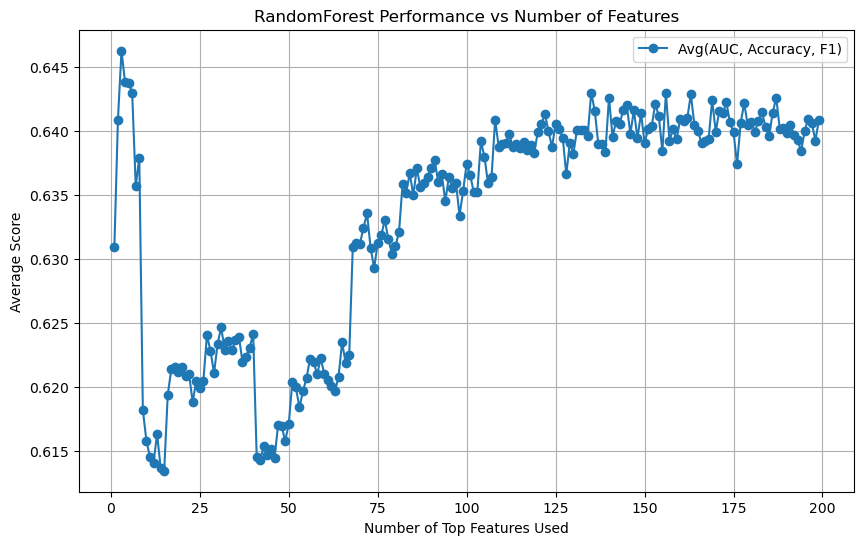

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Features
X_train_all = train_data.drop(columns=['Wellbeing_category'])
X_val_all = val_data.drop(columns=['Wellbeing_category'])

# Loop based on your sorted NMI DataFrame
#feature_order = nmi_df['Feature'].tolist()

#Loop based on the MI after penalizing redundancy
feature_order = selected_features


results = []

for k in range(1, min(200, len(feature_order) + 1)):  # Number of features
    top_features = feature_order[:k]
    
    X_train_k = X_train_all[top_features]
    X_val_k = X_val_all[top_features]
    
    # Train RF
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    rf.fit(X_train_k, y_train)
    
    # Predictions & probabilities
    val_preds = rf.predict(X_val_k)
    val_probs = rf.predict_proba(X_val_k)
    
    # Handle multi-class AUC
    if len(np.unique(y_train)) > 2:
        auc = roc_auc_score(y_val, val_probs, multi_class='ovr')
    else:
        auc = roc_auc_score(y_val, val_probs[:, 1])
    
    acc = accuracy_score(y_val, val_preds)
    f1 = f1_score(y_val, val_preds, average='weighted')
    
    avg_score = np.mean([auc, acc, f1])
    results.append((k, auc, acc, f1, avg_score))

# Convert results to array for plotting
results = np.array(results)
ks = results[:, 0]
avg_scores = results[:, 4]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(ks, avg_scores, marker='o', label='Avg(AUC, Accuracy, F1)')
plt.xlabel('Number of Top Features Used')
plt.ylabel('Average Score')
plt.title('RandomForest Performance vs Number of Features')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
# Sort results by average score in descending order
sorted_results = sorted(results, key=lambda x: x[4], reverse=True)

print("Top 10 feature counts by average score:\n")
for rank, (k, auc, acc, f1, avg) in enumerate(sorted_results[:10], start=1):
    print(f"{rank}. Features: {int(k):3d} | Avg Score: {avg:.4f} | "
          f"AUC: {auc:.4f} | ACC: {acc:.4f} | F1: {f1:.4f}")

Top 10 feature counts by average score:

1. Features:   3 | Avg Score: 0.6463 | AUC: 0.7574 | ACC: 0.5988 | F1: 0.5827
2. Features:   4 | Avg Score: 0.6438 | AUC: 0.7541 | ACC: 0.5979 | F1: 0.5795
3. Features:   5 | Avg Score: 0.6438 | AUC: 0.7529 | ACC: 0.5972 | F1: 0.5814
4. Features:   6 | Avg Score: 0.6430 | AUC: 0.7503 | ACC: 0.5977 | F1: 0.5810
5. Features: 135 | Avg Score: 0.6430 | AUC: 0.7572 | ACC: 0.5979 | F1: 0.5740
6. Features: 156 | Avg Score: 0.6430 | AUC: 0.7566 | ACC: 0.5984 | F1: 0.5740
7. Features: 163 | Avg Score: 0.6429 | AUC: 0.7584 | ACC: 0.5976 | F1: 0.5727
8. Features: 187 | Avg Score: 0.6426 | AUC: 0.7596 | ACC: 0.5971 | F1: 0.5712
9. Features: 140 | Avg Score: 0.6426 | AUC: 0.7548 | ACC: 0.5985 | F1: 0.5745
10. Features: 169 | Avg Score: 0.6424 | AUC: 0.7574 | ACC: 0.5972 | F1: 0.5726



=== Random Forest (Validation) ===
AUC-ROC: 0.7574
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.17      0.25       708
           1       0.39      0.10      0.16      2355
           2       0.50      0.61      0.55      9585
           3       0.70      0.70      0.70     13202

    accuracy                           0.60     25850
   macro avg       0.52      0.40      0.42     25850
weighted avg       0.59      0.60      0.58     25850



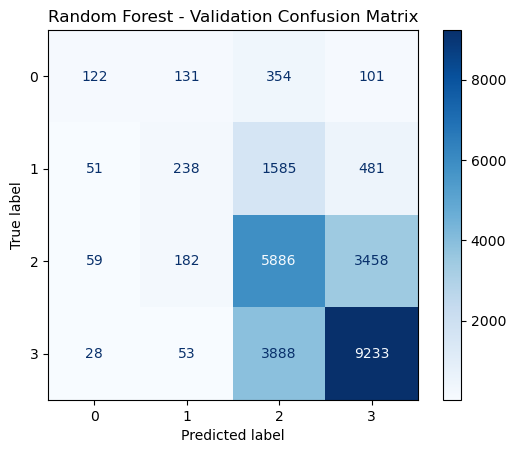


=== XGBoost (Validation) ===
AUC-ROC: 0.7575
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.17      0.25       708
           1       0.40      0.10      0.16      2355
           2       0.50      0.61      0.55      9585
           3       0.70      0.70      0.70     13202

    accuracy                           0.60     25850
   macro avg       0.51      0.40      0.42     25850
weighted avg       0.59      0.60      0.58     25850



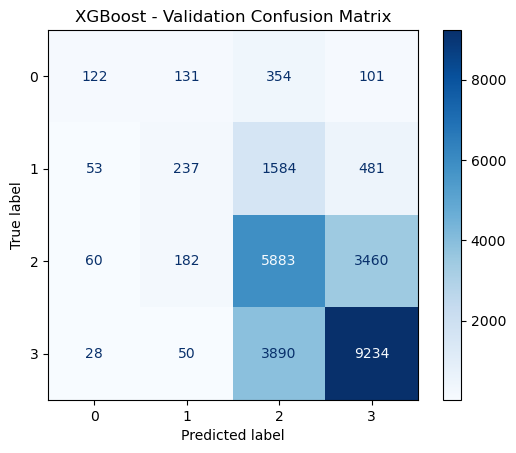


=== Ridge Classifier (Validation) ===
AUC-ROC: 0.7358
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       708
           1       0.00      0.00      0.00      2355
           2       0.47      0.41      0.44      9585
           3       0.62      0.82      0.71     13202

    accuracy                           0.57     25850
   macro avg       0.27      0.31      0.29     25850
weighted avg       0.49      0.57      0.52     25850



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


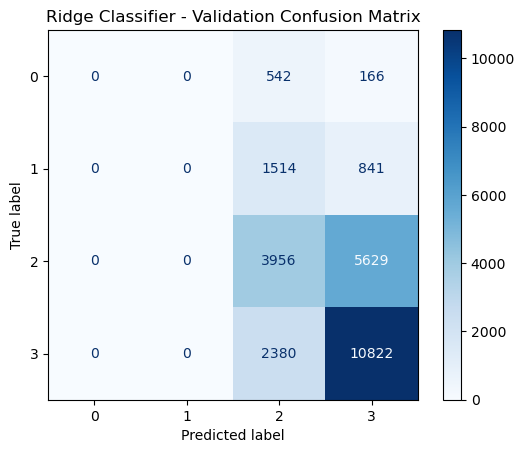


=== Logistic Regression (Validation) ===
AUC-ROC: 0.7380
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.00      0.00       708
           1       1.00      0.00      0.00      2355
           2       0.48      0.46      0.47      9585
           3       0.63      0.80      0.71     13202

    accuracy                           0.58     25850
   macro avg       0.61      0.31      0.29     25850
weighted avg       0.60      0.58      0.53     25850



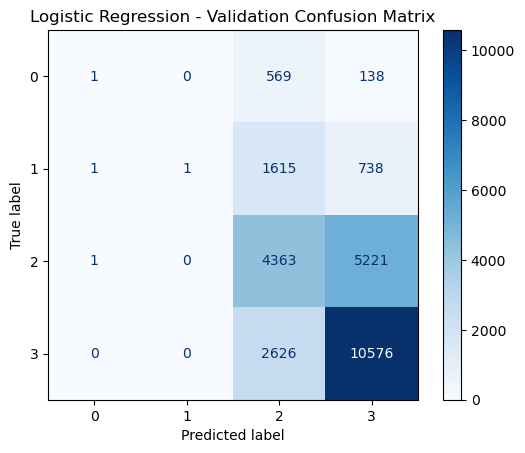


=== Linear SVM (Validation) ===
AUC-ROC: 0.7362
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       708
           1       0.00      0.00      0.00      2355
           2       0.47      0.41      0.44      9585
           3       0.62      0.82      0.71     13202

    accuracy                           0.57     25850
   macro avg       0.27      0.31      0.29     25850
weighted avg       0.49      0.57      0.52     25850



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


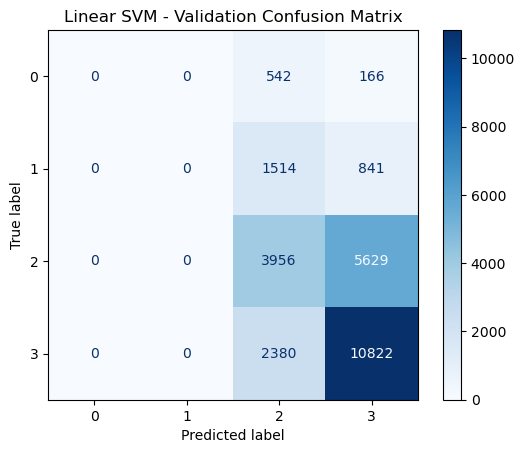


=== KNN (Validation) ===
AUC-ROC: 0.6196
Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.13      0.14       708
           1       0.27      0.14      0.18      2355
           2       0.47      0.47      0.47      9585
           3       0.64      0.70      0.67     13202

    accuracy                           0.55     25850
   macro avg       0.38      0.36      0.37     25850
weighted avg       0.53      0.55      0.53     25850



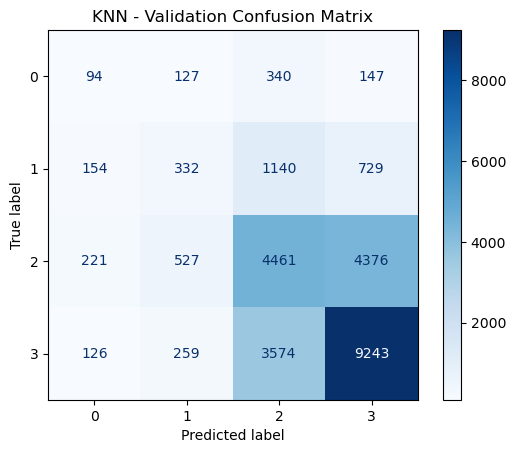


=== MLP Neural Network (Validation) ===
AUC-ROC: 0.7566
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.12      0.19       708
           1       0.37      0.08      0.13      2355
           2       0.50      0.62      0.55      9585
           3       0.69      0.71      0.70     13202

    accuracy                           0.60     25850
   macro avg       0.52      0.38      0.39     25850
weighted avg       0.59      0.60      0.58     25850



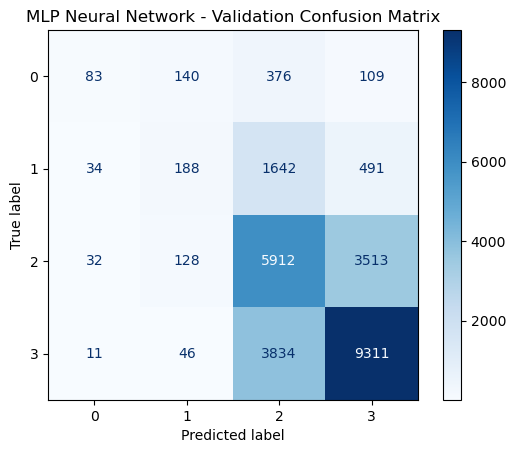

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score
)

# --- Select top MI features ---
top_features = selected_features[:3]

# --- Prepare raw and scaled features ---
X_train_raw = train_data[top_features]
X_val_raw   = val_data[top_features]
X_test_raw  = test_data[top_features]  # reserved for final step

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_val_scaled   = scaler.transform(X_val_raw)
X_test_scaled  = scaler.transform(X_test_raw)  # reserved for final step

# --- Ensure labels are integers ---
y_train_int = y_train.astype(int)
y_val_int   = y_val.astype(int)
y_test_int  = y_test.astype(int)

# --- Define models ---
models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss'),
    "Ridge Classifier": CalibratedClassifierCV(RidgeClassifier(random_state=42)),
    "Logistic Regression": LogisticRegression(
        max_iter=10000, random_state=42, n_jobs=-1, multi_class="multinomial", solver="lbfgs"
    ),
    "Linear SVM": CalibratedClassifierCV(LinearSVC(dual='auto', random_state=42, max_iter=5000)),
    "KNN": KNeighborsClassifier(),
    "MLP Neural Network": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        max_iter=200,
        random_state=42,
        early_stopping=True
    )
}

# --- Training & validation loop ---
val_results = {}

for name, model in models.items():
    print(f"\n=== {name} (Validation) ===")

    # Fit & predict
    if name == "MLP Neural Network":
        model.fit(X_train_scaled, y_train_int)
        preds = model.predict(X_val_scaled)
        probs = model.predict_proba(X_val_scaled) if hasattr(model, "predict_proba") else None
    else:
        model.fit(X_train_raw, y_train_int)
        preds = model.predict(X_val_raw)
        probs = model.predict_proba(X_val_raw) if hasattr(model, "predict_proba") else None

    # --- AUC calculation ---
    if probs is not None:
        if len(np.unique(y_train_int)) > 2:
            auc = roc_auc_score(y_val_int, probs, multi_class='ovr')
        else:
            auc = roc_auc_score(y_val_int, probs[:, 1])
        print(f"AUC-ROC: {auc:.4f}")
    else:
        auc = None
        print("AUC-ROC: Not available (no probability output)")

    # --- Classification Report ---
    print("Classification Report:")
    print(classification_report(y_val_int, preds))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_val_int, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{name} - Validation Confusion Matrix")
    plt.show()

    # Save results
    val_results[name] = {
        "model": model,
        "auc": auc
    }

In [29]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# --- Training & validation loop ---
val_results = []

for name, model in models.items():
    # Fit & predict
    if name == "MLP Neural Network":
        model.fit(X_train_scaled, y_train_int)
        preds = model.predict(X_val_scaled)
        probs = model.predict_proba(X_val_scaled) if hasattr(model, "predict_proba") else None
    else:
        model.fit(X_train_raw, y_train_int)
        preds = model.predict(X_val_raw)
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_val_raw)
        elif hasattr(model, "decision_function"):
            decision_vals = model.decision_function(X_val_raw)
            if decision_vals.ndim == 1:  # binary
                probs = np.vstack([1 - decision_vals, decision_vals]).T
            else:
                probs = decision_vals
        else:
            probs = None

    # --- Metrics ---
    acc = accuracy_score(y_val_int, preds)
    f1  = f1_score(y_val_int, preds, average="weighted")

    if probs is not None:
        if len(np.unique(y_train_int)) > 2:
            auc = roc_auc_score(y_val_int, probs, multi_class='ovr')
        else:
            auc = roc_auc_score(y_val_int, probs[:, 1])
    else:
        auc = np.nan  # no probability output

    # Save results
    val_results.append([name, acc, f1, auc])

# --- Convert results to DataFrame ---
val_summary = pd.DataFrame(val_results, columns=["Model", "Val Accuracy", "Val F1", "Val ROC AUC"])

print("\n=== Model Performance Summary (Validation Data) ===")
print(val_summary.sort_values(by="Val ROC AUC", ascending=False).reset_index(drop=True))


=== Model Performance Summary (Validation Data) ===
                 Model  Val Accuracy    Val F1  Val ROC AUC
0              XGBoost      0.598685  0.582575     0.757538
1        Random Forest      0.598801  0.582725     0.757373
2   MLP Neural Network      0.599381  0.579779     0.756565
3  Logistic Regression      0.577988  0.534238     0.738002
4           Linear SVM      0.571683  0.523725     0.736175
5     Ridge Classifier      0.571683  0.523725     0.735819
6                  KNN      0.546615  0.534831     0.619631



=== Hyperparameter Tuning: Random Forest ===
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Validation - Acc: 0.5988 | F1: 0.5828 | AUC: 0.7576

=== Hyperparameter Tuning: XGBoost ===
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Validation - Acc: 0.5986 | F1: 0.5787 | AUC: 0.7582

=== Hyperparameter Tuning: Ridge Classifier ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'alpha': 0.1, 'solver': 'auto'}
Validation - Acc: 0.5716 | F1: 0.5237 | AUC: 0.7328

=== Hyperparameter Tuning: Logistic Regression ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Validation - Acc: 0.5780 | F1: 0.5342 | AUC: 0.7380

=== Hyperparameter Tuning: Linear SVM =

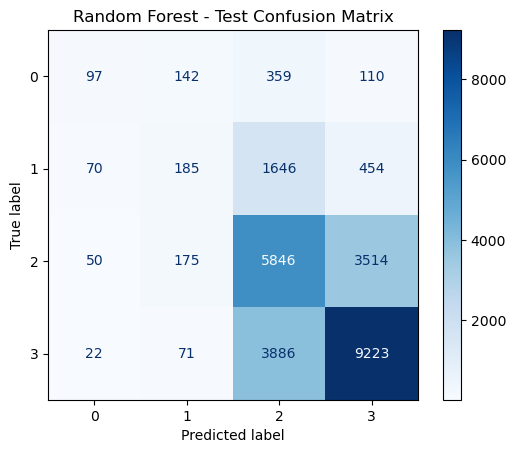


=== Final Test Evaluation: XGBoost ===
Test - Acc: 0.5949 | F1: 0.5738 | AUC: 0.7580


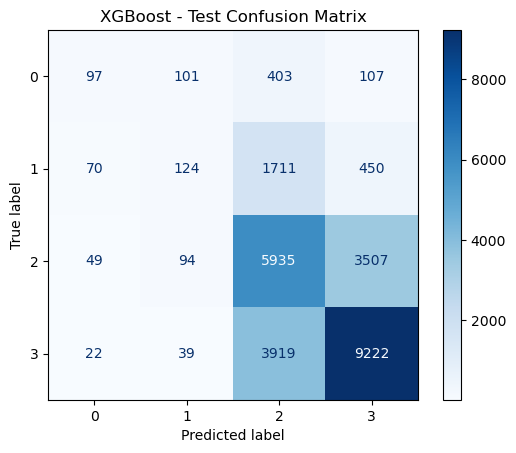


=== Final Test Evaluation: Ridge Classifier ===
Test - Acc: 0.5679 | F1: 0.5198 | AUC: 0.7280


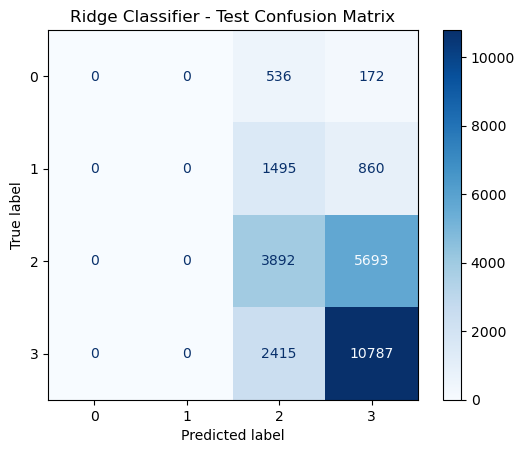


=== Final Test Evaluation: Logistic Regression ===
Test - Acc: 0.5768 | F1: 0.5332 | AUC: 0.7333


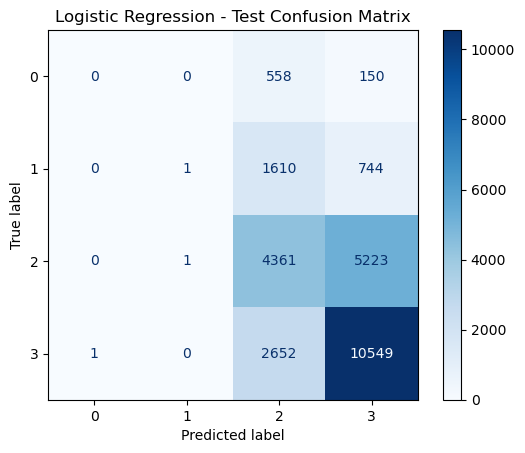


=== Final Test Evaluation: Linear SVM ===
Test - Acc: 0.5679 | F1: 0.5198 | AUC: 0.7285


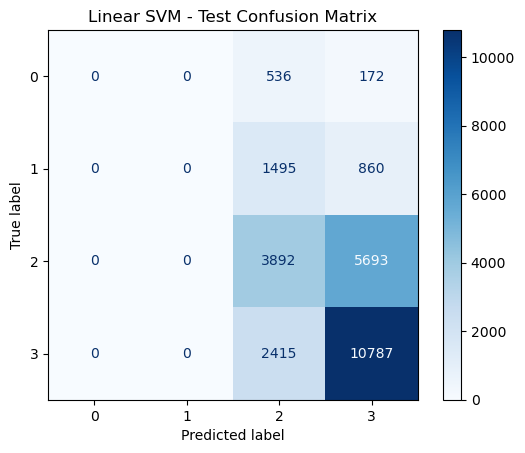


=== Final Test Evaluation: KNN ===
Test - Acc: 0.5373 | F1: 0.5348 | AUC: 0.6470


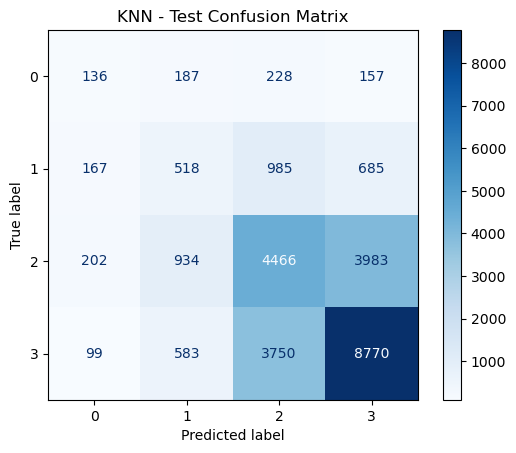


=== Final Test Evaluation: MLP Neural Network ===
Test - Acc: 0.5940 | F1: 0.5724 | AUC: 0.7563


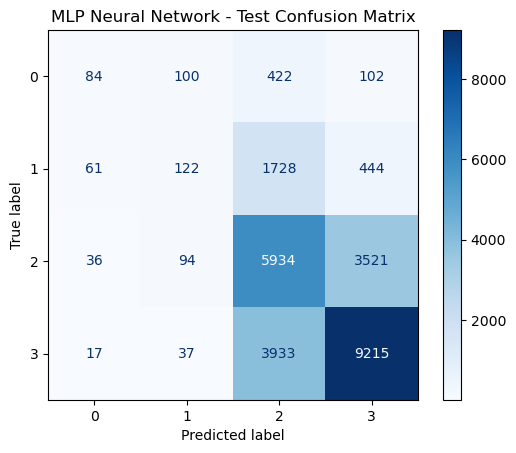


=== Final Model Performance (Test Data) ===
                 Model  Test Accuracy   Test F1  Test ROC AUC
0              XGBoost       0.594894  0.573773      0.758010
1        Random Forest       0.593849  0.575905      0.756773
2   MLP Neural Network       0.594004  0.572402      0.756280
3  Logistic Regression       0.576828  0.533170      0.733320
4           Linear SVM       0.567853  0.519771      0.728473
5     Ridge Classifier       0.567853  0.519771      0.727998
6                  KNN       0.537331  0.534772      0.647031


In [51]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import label_binarize

# --- Select models to fine-tune ---
selected_models = [
    "Random Forest",
    "XGBoost",
    "Ridge Classifier",
    "Logistic Regression",
    "Linear SVM",
    "KNN",
    "MLP Neural Network"
]

# --- Hyperparameter grids ---
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    },
    "Ridge Classifier": {
        "alpha": [0.1, 1.0, 10.0],
        "solver": ["auto", "saga"]
    },
    "Logistic Regression": {
        "C": [0.1, 1.0, 10.0],
        "penalty": ["l2"],
        "solver": ["lbfgs", "saga"]
    },
    "Linear SVM": {
        "C": [0.1, 1.0, 10.0],
        "max_iter": [5000, 10000]
    },
    "KNN": {
        "n_neighbors": [3, 5, 7],
        "weights": ["uniform", "distance"],
        "p": [1, 2]
    },
    "MLP Neural Network": {
        "hidden_layer_sizes": [(64, 32), (128, 64)],
        "activation": ["relu", "tanh"],
        "solver": ["adam"],
        "learning_rate_init": [0.001, 0.01],
        "max_iter": [200, 400]
    }
}

# --- Model objects ---
models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss'),
    "Ridge Classifier": RidgeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=42, n_jobs=-1),
    "Linear SVM": LinearSVC(dual='auto', random_state=42, max_iter=5000),
    "KNN": KNeighborsClassifier(),
    "MLP Neural Network": MLPClassifier(random_state=42, early_stopping=True)
}

# --- Store best models for later test evaluation ---
best_models = {}

# --- Tuning loop (train+val only) ---
for model_name in selected_models:
    print(f"\n=== Hyperparameter Tuning: {model_name} ===")

    # Choose input type
    if model_name == "MLP Neural Network":
        X_train_input, y_train_input = X_train_scaled, y_train_int
        X_val_input, y_val_input = X_val_scaled, y_val_int
    else:
        X_train_input, y_train_input = X_train_raw, y_train_int
        X_val_input, y_val_input = X_val_raw, y_val_int

    # GridSearchCV with validation set (StratifiedKFold CV on training set only)
    grid = GridSearchCV(
        estimator=models[model_name],
        param_grid=param_grids[model_name],
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train_input, y_train_input)

    best_model = grid.best_estimator_

    # Validation performance
    preds_val = best_model.predict(X_val_input)
    if hasattr(best_model, "predict_proba"):
        probs_val = best_model.predict_proba(X_val_input)
    elif hasattr(best_model, "decision_function"):
        decision_vals = best_model.decision_function(X_val_input)
        if decision_vals.ndim == 1:
            probs_val = np.vstack([1 - decision_vals, decision_vals]).T
        else:
            probs_val = decision_vals
    else:
        probs_val = None

    acc = accuracy_score(y_val_input, preds_val)
    f1  = f1_score(y_val_input, preds_val, average='weighted')
    if probs_val is not None:
        if len(np.unique(y_train_input)) > 2:
            auc = roc_auc_score(label_binarize(y_val_input, classes=np.unique(y_val_input)),
                                probs_val, multi_class='ovr', average='macro')
        else:
            auc = roc_auc_score(y_val_input, probs_val[:, 1])
    else:
        auc = None

    print(f"Best params: {grid.best_params_}")
    print(f"Validation - Acc: {acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

    # Save tuned model
    best_models[model_name] = best_model

# --- Final test evaluation with best models ---
test_results = []
for model_name, best_model in best_models.items():
    print(f"\n=== Final Test Evaluation: {model_name} ===")

    # Choose input type
    if model_name == "MLP Neural Network":
        X_test_input, y_test_input = X_test_scaled, y_test_int
        X_trainval_input = np.vstack([X_train_scaled, X_val_scaled])
        y_trainval_input = np.concatenate([y_train_int, y_val_int])
    else:
        X_test_input, y_test_input = X_test_raw, y_test_int
        X_trainval_input = pd.concat([X_train_raw, X_val_raw])
        y_trainval_input = np.concatenate([y_train_int, y_val_int])

    # Retrain best model on train+val
    best_model.fit(X_trainval_input, y_trainval_input)

    preds = best_model.predict(X_test_input)
    if hasattr(best_model, "predict_proba"):
        probs = best_model.predict_proba(X_test_input)
    elif hasattr(best_model, "decision_function"):
        decision_vals = best_model.decision_function(X_test_input)
        if decision_vals.ndim == 1:
            probs = np.vstack([1 - decision_vals, decision_vals]).T
        else:
            probs = decision_vals
    else:
        probs = None

    acc = accuracy_score(y_test_input, preds)
    f1  = f1_score(y_test_input, preds, average='weighted')
    if probs is not None:
        if len(np.unique(y_trainval_input)) > 2:
            auc = roc_auc_score(label_binarize(y_test_input, classes=np.unique(y_test_input)),
                                probs, multi_class='ovr', average='macro')
        else:
            auc = roc_auc_score(y_test_input, probs[:, 1])
    else:
        auc = None

    print(f"Test - Acc: {acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test_input, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} - Test Confusion Matrix")
    plt.show()

    test_results.append([model_name, acc, f1, auc])

# --- Summarize test results ---
test_summary = pd.DataFrame(test_results, columns=["Model", "Test Accuracy", "Test F1", "Test ROC AUC"])
print("\n=== Final Model Performance (Test Data) ===")
print(test_summary.sort_values(by="Test ROC AUC", ascending=False).reset_index(drop=True))

In [53]:
# --- Save best models ---
if model_name in ["XGBoost", "MLP Neural Network"]:
    if "best_models" not in globals():
        best_models = {}
    best_models[model_name] = best_model